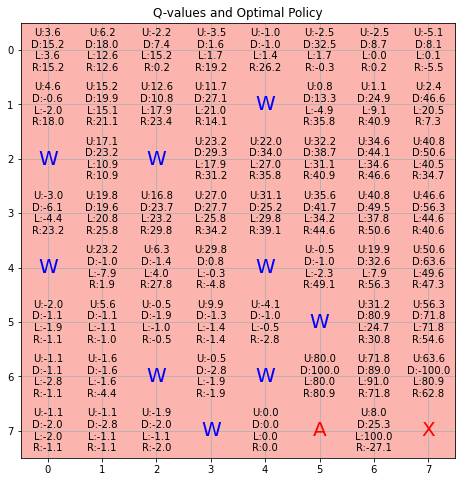

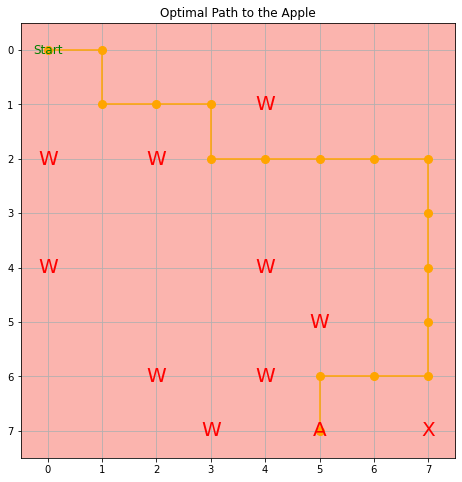

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define the environment (8x8 grid) for Peter's world
# S - Start, G - Grass, T - Tree, A - Apple, W - Water, X - Wolf (danger)
grid_world = np.array([
    ['S','.','.','.','.','.','.','.'],
    ['.','.','T','.','W','G','.','.'],
    ['W','.','W','.','.','.','.','G'],
    ['T','T','.','.','.','.','.','T'],
    ['W','.','.','G','W','T','.','.'],
    ['.','.','.','.','.','W','.','.'],
    ['.','T','W','.','W','G','.','.'],
    ['.','.','.','W','.','A','.','X'],
])

# Define the reward structure
reward_mapping = {
    'G': 1,   # Grass - Positive reward
    'W': -20, # Water - Impassable, large negative reward
    'A': 100, # Apple - High reward
    'X': -100,# Wolf (danger) - Huge penalty (game over)
    '.': -1,  # Neutral movement cost
    'T': 0    # Tree - No penalty, but resting place
}

# Get starting position of Peter (S)
initial_pos = tuple(np.argwhere(grid_world == 'S')[0])

# Hyperparameters for Q-learning
learning_rate = 0.1    # Alpha
discount_factor = 0.9   # Gamma
exploration_rate = 0.2  # Epsilon

# Define actions: Up, Down, Left, Right
actions = ['up', 'down', 'left', 'right']
action_mapping = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
q_values = np.zeros((8, 8, len(actions)))  # Q-table

# Helper function to check if the move is valid (inside the grid and not into water)
def valid_move(pos):
    x, y = pos
    if 0 <= x < 8 and 0 <= y < 8:  # Stay within grid boundaries
        return grid_world[x, y] != 'W'  # Water is not walkable
    return False

# Reward for the new state
def reward_at(state):
    x, y = state
    return reward_mapping.get(grid_world[x, y], -1)

# Function to take a step
def step(state, action):
    x, y = state
    dx, dy = action_mapping[action]
    new_pos = (x + dx, y + dy)

    if valid_move(new_pos):
        reward = reward_at(new_pos)
        return new_pos, reward
    return state, -10  # Invalid move gets negative reward

# Q-Learning Algorithm
def train_q_learning(episodes=4000):
    global exploration_rate
    for episode in range(episodes):
        state = initial_pos
        finished = False

        while not finished:
            # Select action based on epsilon-greedy strategy
            if random.uniform(0, 1) < exploration_rate:
                action = random.choice(actions)  # Explore
            else:
                action = actions[np.argmax(q_values[state[0], state[1]])]  # Exploit

            # Take the action and observe the new state and reward
            new_state, reward = step(state, action)
            old_q_value = q_values[state[0], state[1], actions.index(action)]
            future_q_value = np.max(q_values[new_state[0], new_state[1]])

            # Update Q-value using the Bellman equation
            q_values[state[0], state[1], actions.index(action)] = old_q_value + \
                learning_rate * (reward + discount_factor * future_q_value - old_q_value)

            # Move to the new state
            state = new_state

            # End episode if reaching terminal state (apple or wolf)
            if grid_world[state[0], state[1]] in ['A', 'X']:
                finished = True

        # Gradually reduce exploration over time
        exploration_rate = max(0.1, exploration_rate * 0.99)

# Train the model
train_q_learning()

# Function to visualize Q-values and the optimal policy
def plot_policy():
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(np.zeros((8, 8)), cmap='Pastel1')

    # Set gridlines and labels
    for i in range(8):
        for j in range(8):
            if grid_world[i, j] == 'W':  # Water
                ax.text(j, i, 'W', ha='center', va='center', color='blue', fontsize=20)
            elif grid_world[i, j] in ['A', 'X']:  # Apple or Wolf
                ax.text(j, i, grid_world[i, j], ha='center', va='center', fontsize=20, color='red')
            else:  # For empty, grass, or tree cells, show Q-values
                q_vals = q_values[i, j]
                ax.text(j, i, f'U:{q_vals[0]:.1f}\nD:{q_vals[1]:.1f}\nL:{q_vals[2]:.1f}\nR:{q_vals[3]:.1f}', 
                        ha='center', va='center', fontsize=10)

    plt.grid(True)
    plt.title("Q-values and Optimal Policy")
    plt.show()

# Display the learned policy
plot_policy()

# Function to trace the optimal path to the apple
def find_optimal_path(start):
    state = start
    path = [state]

    while True:
        i, j = state
        if grid_world[i, j] in ['A', 'X']:  # Stop when reaching Apple or Wolf
            break

        # Choose the best action based on Q-values
        best_action_idx = np.argmax(q_values[i, j])
        best_action = actions[best_action_idx]

        # Take the action
        if best_action == 'up' and i > 0:
            state = (i - 1, j)
        elif best_action == 'down' and i < 7:
            state = (i + 1, j)
        elif best_action == 'left' and j > 0:
            state = (i, j - 1)
        elif best_action == 'right' and j < 7:
            state = (i, j + 1)

        path.append(state)

    return path

# Plot the path
def plot_optimal_path(path):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(np.zeros((8, 8)), cmap='Pastel1')

    # Plot the environment with the path
    for i in range(8):
        for j in range(8):
            cell = grid_world[i, j]
            if cell in ['W', 'A', 'X']:
                ax.text(j, i, cell, ha='center', va='center', fontsize=20, color='red')
            elif cell == 'S':
                ax.text(j, i, 'Start', ha='center', va='center', color='green', fontsize=12)

    # Plot the path Peter takes
    x_vals, y_vals = zip(*path)
    ax.plot(y_vals, x_vals, marker='o', color='orange', markersize=8, label='Path')

    plt.title("Optimal Path to the Apple")
    plt.grid(True)
    plt.show()

# Find and visualize the optimal path
optimal_path = find_optimal_path(initial_pos)
plot_optimal_path(optimal_path)


In [15]:
import numpy as np
import random
import plotly.graph_objects as go

# Define the environment (8x8 grid) with multiple apples
environment = np.array([
    ['.','.','.','.','.','.','.','.'],
    ['.','.','.','.','.','G','.','.'],
    ['W','.','W','A','.','.','.','G'],
    ['W','W','.','.','P','.','.','.'],
    ['W','.','A','.','W','G','.','.'],
    ['.','.','.','.','.','W','.','.'],
    ['.','.','W','.','W','G','.','G'],
    ['.','.','.','W','.','A','.','D'],
])

# Rewards for different items in the grid
reward_map = {
    'G': 1,    # Grass - Low reward
    'W': -10,  # Water - Impassable, large negative reward
    'A': 100,  # Apple - Large reward
    'D': -100, # Wolf (danger) - Huge negative penalty (game over)
    '.': -1    # Normal movement penalty
}

# Initial parameters
start_position = tuple(np.argwhere(environment == 'P')[0])  # Starting location of Peter ('P')
alpha = 0.3   # Learning rate
gamma = 0.9   # Discount factor
epsilon = 0.2 # Exploration rate

# Actions: up, down, left, right
actions = ['up', 'down', 'left', 'right']
action_dict = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

# Initialize Q-table: dimensions (8x8 grid) x 4 actions
q_table = np.zeros((8, 8, len(actions)))

# Helper function to locate apples
def find_apples(env):
    return [(i, j) for i in range(8) for j in range(8) if env[i, j] == 'A']

# Check if a state is valid (within bounds and not blocked by water)
def is_valid_state(state):
    x, y = state
    return 0 <= x < 8 and 0 <= y < 8 and environment[x, y] != 'W'

# Get reward for a given state
def get_reward(state):
    return reward_map.get(environment[state], -1)

def take_action(state, action):
    dx, dy = action_dict[action]
    new_state = (state[0] + dx, state[1] + dy)
    
    if not is_valid_state(new_state):
        return state, -10  # No movement, negative reward

    # Prevent cycles (moving back and forth)
    if new_state == state:
        return state, -5  # Penalize repeated moves

    return new_state, get_reward(new_state)

# Slow down the epsilon decay
epsilon = max(0.1, epsilon * 0.999)

# Q-Learning algorithm
def q_learning(num_episodes=5000):
    global epsilon
    for episode in range(num_episodes):
        state = start_position
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(actions)
            else:
                action = actions[np.argmax(q_table[state])]

            new_state, reward = take_action(state, action)
           
            best_future_q = np.max(q_table[new_state])
            action_index = actions.index(action)
            q_table[state][action_index] += alpha * (reward + gamma * best_future_q - q_table[state][action_index])
            
            state = new_state

            if environment[state] in ['A', 'D']:
                done = True
        
        epsilon = max(0.1, epsilon * 0.99)

# Train the model for each apple collection
def collect_all_apples(start_position):
    apples = find_apples(environment)  # Find all apple positions
    route = []
    current_position = start_position
    
    while apples:  # Continue until all apples are collected
        q_learning(num_episodes=5000)  # Train Q-learning
        
        # Find optimal route to the nearest apple
        nearest_apple = min(apples, key=lambda a: np.linalg.norm(np.array(a) - np.array(current_position)))
        optimal_route = find_optimal_route(current_position, nearest_apple)
        route.append(optimal_route)
        
        # Update environment (mark apple as collected)
        environment[nearest_apple] = '.'
        apples.remove(nearest_apple)
        
        # Set current position to the newly collected apple
        current_position = nearest_apple
    
    return route

def find_optimal_route(start, goal, max_steps=100):
    state = start
    route = [state]
    steps = 0

    while state != goal and steps < max_steps:
        if not is_valid_state(state):
            break  # Exit if the state is invalid
        action = actions[np.argmax(q_table[state])]
        state, _ = take_action(state, action)
        route.append(state)
        steps += 1
    
    # Return route or None if goal wasn't reached within max_steps
    return route if state == goal else None

# Plot the optimal route using plotly (Flip only the grid, not the routes)
def plot_optimal_route(routes):
    fig = go.Figure()

    # Add environment elements (apples, water, etc.)
    for i in range(8):
        for j in range(8):
            # Flip vertically by replacing i with 7-i
            cell = environment[i, j]
            color = 'lightgray'
            if cell == 'W':
                color = 'blue'
            elif cell == 'A':
                color = 'green'
            elif cell == 'D':
                color = 'red'
            elif cell == 'G':
                color = 'yellow'

            # Flip the grid (i becomes 7-i, but keep j the same)
            fig.add_trace(go.Scatter(
                x=[j], y=[i], mode='markers+text',  # Flip y-coordinate for grid only
                marker=dict(size=40, color=color, symbol='square'),
                text=cell, textposition='middle center',
                showlegend=False
            ))

    # Add paths (unchanged)
    for idx, route in enumerate(routes):
        if route:
            xs, ys = zip(*[(p[1], p[0]) for p in route])  # Do not flip the path
            fig.add_trace(go.Scatter(
                x=xs, y=ys, mode='lines+markers', name=f'Path {idx+1}',
                line=dict(color=f'rgba({random.randint(0,255)}, {random.randint(0,255)}, {random.randint(0,255)}, 0.8)', width=3),
                marker=dict(size=8)
            ))

    fig.update_layout(
        title="Peter's Optimal Routes to Collect All Apples (Grid Flipped Vertically)",
        xaxis=dict(range=[-0.5, 7.5], scaleanchor="y"),
        yaxis=dict(range=[-0.5, 7.5]),
        showlegend=True
    )
    fig.show()

# Collect all apples and plot the final route
routes = collect_all_apples(start_position)
plot_optimal_route(routes)
